# Assignment 1 

## First draft
### Youssef Ragab, Ting Huang


**1. Loading in the required libraries:**

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import h2o 
from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch 
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator 
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.frame import H2OFrame      
import itertools       
import matplotlib.pyplot as plt        
import xgboost as xgb 
import time 
import seaborn as sns 
import numpy as np
import datetime

Initializations: 

In [2]:
Seed = 2021

nthreads = 4

h2o.init(max_mem_size= '6G', nthreads= nthreads)
h2o.remove_all()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 day 2 hours 52 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_tinghuang_rodxig
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.162 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Start global timer:

In [3]:
tic = time.time()

Importing data: 

In [4]:
train = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

In [5]:
train.columns

Index(['row_id', 'black', 'asian', 'white', 'amind', 'hipac', 'hispanic',
       'non_hispanic', 'male', 'female', 'agegte62', 'agelt62', 'term_360',
       'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std',
       'loan_to_value_ratio_std', 'no_intro_rate_period_std',
       'intro_rate_period_std', 'property_value_std', 'income_std',
       'debt_to_income_ratio_std', 'high_priced'],
      dtype='object')

In [6]:
test.columns

Index(['row_id', 'black', 'asian', 'white', 'amind', 'hipac', 'hispanic',
       'non_hispanic', 'male', 'female', 'agegte62', 'agelt62', 'term_360',
       'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std',
       'loan_to_value_ratio_std', 'no_intro_rate_period_std',
       'intro_rate_period_std', 'property_value_std', 'income_std',
       'debt_to_income_ratio_std'],
      dtype='object')

Now that we have the datasets loaded, we can proceed and remove the columns that we don't need from the training set. Based on the assignment prompt, we are going to keep the following variables:
* high_priced
* conforming 
* debt_to_income_ratio_std
* debt_to_income_ratio_missing
* income_std 
* loan_amount_std
* intro_rate_period_std
* loan_to_value_ratio_std
* no_intro_rate_period_std
* property_value_std
* term_360

In [7]:
x_name = ['conforming', 'debt_to_income_ratio_std', 'debt_to_income_ratio_missing', 'income_std', 'loan_amount_std', 'intro_rate_period_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std', 'property_value_std', 'term_360']
y_name = 'high_priced'

train = train[x_name + [y_name]]

Now that we have only kept the columns that we need from the training set, we can do the same for the testing or validation set. 

In [8]:
test = test[x_name]
test.columns

Index(['conforming', 'debt_to_income_ratio_std',
       'debt_to_income_ratio_missing', 'income_std', 'loan_amount_std',
       'intro_rate_period_std', 'loan_to_value_ratio_std',
       'no_intro_rate_period_std', 'property_value_std', 'term_360'],
      dtype='object')

### Data exploration:

**Histograms:**

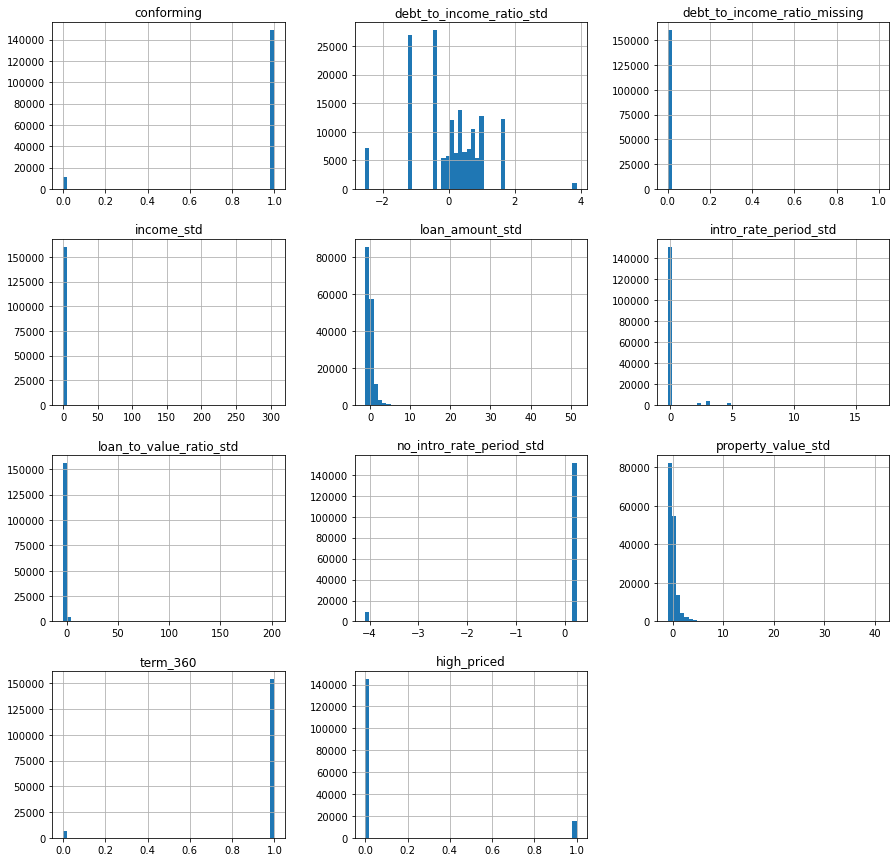

In [9]:
_ = train.hist(bins = 50, figsize= (15,15))

**Correlation:**

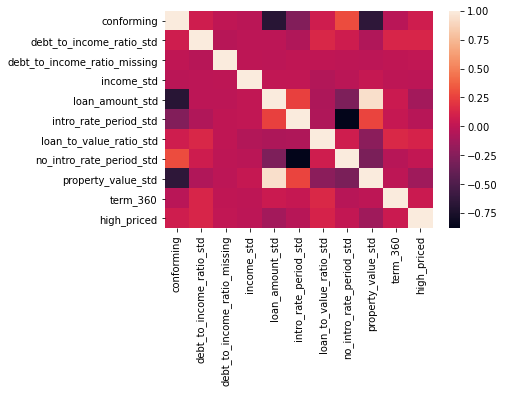

In [10]:
_ = sns.heatmap(train.corr(),
                xticklabels= train.columns.values,
                yticklabels= train.columns.values)

Since the testing set does not have the y column, there is no need to add it, and we are left with the same variables as the training set. 

We can move ahead to training the model. 

### Fitting interpretable models: 

**Splitting data into training and validation subsets:**

In [11]:
np.random.seed(Seed)

split_ratio = 0.7

split = np.random.rand(len(train)) < split_ratio

training = train[split]
validation = train[~split]

print('Train data rows = %d, columns = %d' % (training.shape[0], training.shape[1]))
print('Train data rows = %d, columns = %d' % (validation.shape[0], validation.shape[1])) 


Train data rows = 112085, columns = 11
Train data rows = 48253, columns = 11


### Elastic Net

**Defining wrapper function for hyperparameter grid search:**

In [12]:
def glm_grid(x_name, y_name, htrain, hvalid, seed):

    # Creating alpha options to set L2:
    alpha_options = [0.1, 0.25, 0.5, 0.99]
    
    # Defining serch criteria
    hyperparameters = {'alpha': alpha_options}

    # Initializing grid 
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(family = 'binomial',
                                      lambda_search = True,
                                      seed = seed),
        hyper_params = hyperparameters)

    # Executing training with grid search
    grid.train(y = y_name,
               x = x_name,
               training_frame = htrain, 
               validation_frame = hvalid,
               seed = seed)

    # Choosing the best model from the grid seach 
    best_model = grid.get_grid()[0]
    del grid 

    return best_model


**Fitting elastic net:**

In [13]:
# Start timer 
glm_tic = time.time()

# Converting data into H2O Frame 
htrain = h2o.H2OFrame(training)
hvalid = h2o.H2OFrame(validation)

# Training with grid search 
best_glm = glm_grid(x_name, y_name, htrain, hvalid, Seed)

# End timer 
glm_toc = time.time() - glm_tic
print('Elastic net GLM training completed in %.2f s.' % glm_toc)

Elastic net GLM training completed in 9.90 s.


**Best AUC assessment:**

In [14]:
print('Validation AUC: %.4f.' % best_glm.auc(valid = True))

Validation AUC: 0.7563.


**Writing submission files:**

In [15]:
best_glm_submit = best_glm.predict(h2o.H2OFrame(test)).as_data_frame()
best_glm_submit.drop(['predict', 'p0'], axis = 1, inplace = True)
best_glm_submit.columns = ['phat']
best_glm_submit.to_csv('best_glm_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                        index=False)

In [16]:
best_glm_submit

,phat
0,0.143548
1,0.081622
2,0.128239
3,0.005961
4,0.131591
...,...
19826,0.162954
19827,0.124602
19828,0.170077
19829,0.002077


### Monotonic XGBoost
**Define utility function for random grid search**

In [17]:
def xgb_grid(dtrain, dvalid, mono_constraints=None, gs_params=None, n_models=None,
             ntree=None, early_stopping_rounds=None, verbose=False, seed=None):
    

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(Seed) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for objective,  etc.
    params = {'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': nthreads,
              'objective': 'binary:logistic',
              'seed': Seed}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train on current params
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        
        if mono_constraints is not None:
            params['monotone_constraints'] = mono_constraints
        
        candidate = xgb.train(params,
                              dtrain,
                              ntree,
                              early_stopping_rounds=early_stopping_rounds,
                              evals=watchlist,
                              verbose_eval=verbose)    

        # determine if current model is better than previous best
        if candidate.best_score > best_score:
            best_candidate = candidate
            best_score = candidate.best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate.best_score))

        print('---------- ----------')
            
    return best_candidate

**Fit monotonic XGBoost with random grid search**

In [18]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
             'colsample_bylevel': [0.3, 0.5, 0.7, 0.9],
             'eta': [0.005, 0.05, 0.5],
             'max_depth': [3, 5, 7],
             'reg_alpha': [0.0005, 0.005, 0.05],
             'reg_lambda': [0.0005, 0.005, 0.05],
             'subsample': [0.3, 0.5, 0.7, 0.9],
             'min_child_weight': [1, 5, 10], 
             'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4]}

# define monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train[x_name + [y_name]].corr()[y_name].values[:-1])])

# start local timer
mxgb_tic = time.time()

# Convert data to SVMLight format
dtrain = xgb.DMatrix(training[x_name], training[y_name])
dvalid = xgb.DMatrix(validation[x_name], validation[y_name])

# Monotonic XGBoost grid search
best_mxgb = xgb_grid(dtrain, dvalid, gs_params=gs_params, n_models=50, ntree=1000, early_stopping_rounds=100, 
                     mono_constraints=mono_constraints, seed=Seed)

# end local timer
mxgb_toc = time.time() - mxgb_tic
print('Monotonic GBM training completed in %.2f s.' % (mxgb_toc))

Grid search run 1/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 2021, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.1}
Grid search new best score discovered at iteration 1/50: 0.7717.
---------- ----------
Grid search run 2/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 2021, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constraints': (1, 1, 1, -1, -1, -1, 1, 1, -1, 1)}
Grid search new best score discovered at iteration 2/50: 0.7871.
---------- ----------
Grid search run 3/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'obj

Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 2021, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.9, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.2, 'monotone_constraints': (1, 1, 1, -1, -1, -1, 1, 1, -1, 1)}
---------- ----------
Grid search run 40/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 2021, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.2, 'monotone_constraints': (1, 1, 1, -1, -1, -1, 1, 1, -1, 1)}
---------- ----------
Grid search run 41/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 2021, 'colsample_bytree': 0.9, 'colsample_bylevel'

**Basic AUC assessment**

In [19]:
print('Validation AUC: %.4f.' % best_mxgb.best_score)

Validation AUC: 0.7913.


**Write submission file**

In [20]:
dtest = xgb.DMatrix(test[x_name])
best_mxgb_submit = pd.DataFrame(best_mxgb.predict(dtest, ntree_limit=best_mxgb.best_ntree_limit), columns=['phat'])
best_mxgb_submit.to_csv('ph_best_mxgb_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                        index=False)

In [21]:
best_mxgb_submit

,phat
0,0.066214
1,0.034362
2,0.171752
3,0.031721
4,0.176927
...,...
19826,0.245008
19827,0.175831
19828,0.225311
19829,0.000893


### Random forest 

In [22]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    print()
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame

In [23]:
H2OFrame(training[x_name])

conforming,debt_to_income_ratio_std,debt_to_income_ratio_missing,income_std,loan_amount_std,intro_rate_period_std,loan_to_value_ratio_std,no_intro_rate_period_std,property_value_std,term_360
1,0.854601,0,-0.0403074,-0.514393,-0.215304,0.333922,0.244394,-0.535932,1
1,0.123326,0,-0.0323383,-0.778227,4.61086,0.228996,-4.09175,-0.720941,1
1,-0.425131,0,-0.0181326,-0.0746695,-0.215304,-1.15024,0.244394,0.358276,1
1,0.397554,0,-0.0247158,-0.338504,-0.215304,0.372784,0.244394,-0.412593,1
1,1.03742,0,-0.0209045,-0.426448,-0.215304,0.355249,0.244394,-0.474263,1
1,0.0319161,0,-0.019865,0.277109,-0.215304,0.142995,0.244394,0.111598,1
1,0.94601,0,-0.0281806,-0.382476,-0.215304,-0.240432,0.244394,-0.320089,1
1,-1.15641,0,0.0165154,0.10122,-0.215304,-0.266529,0.244394,0.111598,1
1,-1.15641,0,0.00300267,-0.0746695,-0.215304,0.154744,0.244394,-0.165915,1
1,-1.15641,0,-0.0274876,-0.426448,-0.215304,0.355249,0.244394,-0.474263,1


In [24]:
rf_model1 = H2ORandomForestEstimator(
    ntrees=10000,                    
    max_depth=10, 
    col_sample_rate_per_tree=0.1,
    sample_rate=0.8,
    stopping_rounds=50,
    score_each_iteration=True,
    nfolds=3,
    keep_cross_validation_predictions=True,
    seed=12345)           

# start timer 
rf_tic = time.time()

# train rf model
rf_model1.train(
    y = 'high_priced',
    training_frame=H2OFrame(training),
    validation_frame=H2OFrame(validation))

# print model information
rf_toc = time.time() - rf_tic
print('Random Forest training completed in %.2f s.' % rf_toc)
print(rf_model1)


rf_preds1_test = rf_model1.predict(H2OFrame(test))
gen_submission(rf_preds1_test) # 0.14574 public leaderboard

Random Forest training completed in 77.81 s.
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1622323420230_28


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,105.0,105.0,94848.0,1.0,10.0,5.457143,2.0,327.0,67.37143




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.08425442511122368
RMSE: 0.2902661280811519
MAE: 0.17112324913500115
RMSLE: 0.20184156836575237
Mean Residual Deviance: 0.08425442511122368

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.08395511251845776
RMSE: 0.2897500863131153
MAE: 0.1708975885365749
RMSLE: 0.20143578005147492
Mean Residual Deviance: 0.08395511251845776

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.08415171702485157
RMSE: 0.2900891535801564
MAE: 0.17107968414286878
RMSLE: 0.20166118013329773
Mean Residual Deviance: 0.08415171702485157

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
0,mae,0.17107706,5.826294E-4,0.17142561,0.17040445,0.17140113
1,mean_residual_deviance,0.08414648,0.0011620085,0.08484964,0.08280523,0.08478455
2,mse,0.08414648,0.0011620085,0.08484964,0.08280523,0.08478455
3,r2,0.037188496,0.0010438386,0.036885176,0.038350403,0.036329914
4,residual_deviance,0.08414648,0.0011620085,0.08484964,0.08280523,0.08478455
5,rmse,0.29007548,0.002006936,0.29128963,0.28775898,0.29117787
6,rmsle,0.2016535,0.0011916215,0.20235947,0.20027769,0.20232332



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-05-30 20:35:08,42.638 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-05-30 20:35:08,42.717 sec,1.0,0.299491,0.177025,0.089695,0.295305,0.174560,0.087205
2,,2021-05-30 20:35:08,42.784 sec,2.0,0.296791,0.175427,0.088085,0.295305,0.174560,0.087205
3,,2021-05-30 20:35:08,42.843 sec,3.0,0.296184,0.175073,0.087725,0.295305,0.174560,0.087205
4,,2021-05-30 20:35:08,42.896 sec,4.0,0.295920,0.174796,0.087568,0.294874,0.174302,0.086951
5,,2021-05-30 20:35:08,42.955 sec,5.0,0.294921,0.173625,0.086978,0.292509,0.172656,0.085562
6,,2021-05-30 20:35:08,42.997 sec,6.0,0.295426,0.174094,0.087276,0.292929,0.172988,0.085808
7,,2021-05-30 20:35:08,43.056 sec,7.0,0.294675,0.173514,0.086833,0.292289,0.172535,0.085433
8,,2021-05-30 20:35:08,43.116 sec,8.0,0.294301,0.173086,0.086613,0.291824,0.172134,0.085161
9,,2021-05-30 20:35:08,43.182 sec,9.0,0.292753,0.171808,0.085705,0.290014,0.170941,0.084108



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_std,8662.430664,1.000000,0.414162
1,property_value_std,5277.512695,0.609242,0.252325
2,debt_to_income_ratio_std,2580.519775,0.297898,0.123378
3,income_std,1840.750610,0.212498,0.088009
4,loan_amount_std,1048.941040,0.121091,0.050151
5,intro_rate_period_std,750.020264,0.086583,0.035859
6,term_360,374.674194,0.043253,0.017914
7,conforming,323.636749,0.037361,0.015473
8,no_intro_rate_period_std,43.214840,0.004989,0.002066
9,debt_to_income_ratio_missing,13.849764,0.001599,0.000662


NameError: name 'gen_submission' is not defined

In [25]:
best_rf_submit = rf_model1.predict(H2OFrame(test)).as_data_frame()
best_rf_submit.to_csv('best_rf_model_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                        index=False)


In [26]:
best_rf_submit

,predict
0,0.100704
1,0.098442
2,0.119991
3,0.065078
4,0.117926
...,...
19826,0.124180
19827,0.105582
19828,0.127146
19829,0.056343
